In [1]:
import spherical_inr as sph
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import s2fft
import utils
import numpy as np

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


In [ ]:
class ToCart(torch.nn.Module):
    def forward(self, x):
        return sph._coords.tp_to_r3(x)

In [3]:
LINIT = 5

In [4]:
hnet_pe = nn.Sequential(
    ToCart(),
    sph.HerglotzPE(
        num_atoms=100,  
        L_init=LINIT
    )
)


In [5]:
phi, theta, (nlon, nlat) = utils.sample_s2(L = 50, sampling = "gl")
x = torch.stack([theta.flatten(), phi.flatten()], dim=-1).float()

In [6]:
yinit = hnet_pe(x).reshape(nlat, nlon, -1)

In [7]:
sh_transforms_init = []

for i in range(yinit.size(-1)):
    yi = yinit[..., i].detach().numpy()
    sh_transform = s2fft.forward_numpy(yi, L = 50, sampling = "gl")
    sh_transforms_init.append(sh_transform)

sh_transforms_init = np.sum(sh_transforms_init, axis=0)

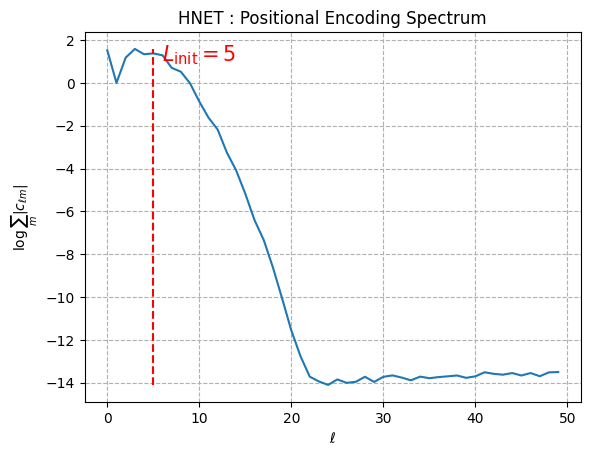

In [8]:
log_abs_coeffs = np.log(np.sum(np.abs(sh_transforms_init), axis = -1))
plt.plot(log_abs_coeffs)
plt.vlines(LINIT, np.min(log_abs_coeffs), np.max(log_abs_coeffs), linestyle = "--", color ="red")
plt.text(LINIT + 1, 1, s = r"$L_{\text{init}} = $" + str(LINIT), fontdict=dict(color ="red", fontsize = 15))
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\log \sum_{m}|c_{\ell m}|$")
plt.grid(linestyle = "--")
plt.title("HNET : Positional Encoding Spectrum")
plt.show()

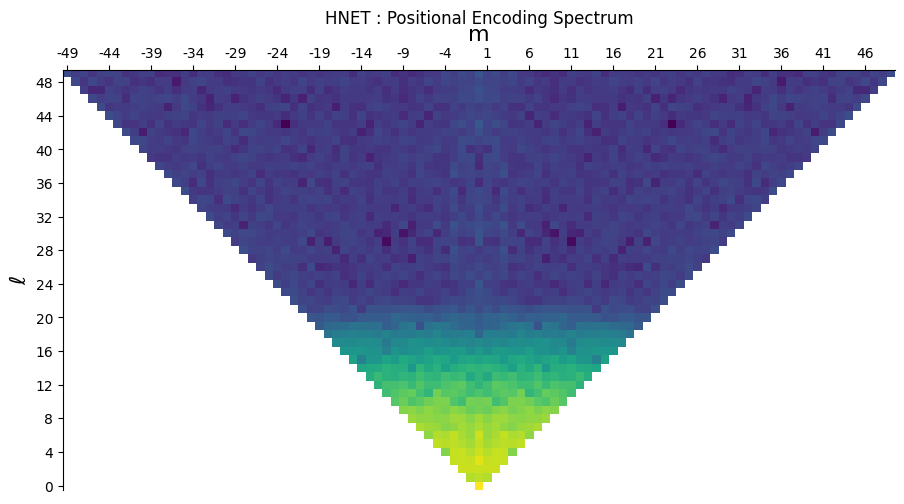

In [9]:
fig = plt.figure(figsize=(12, 5))
im = utils.plot_SHT_coeffs(sh_transforms_init, ticks_m=5, ticks_l=4, fig = fig, cmap = "viridis",)
fig.suptitle("HNET : Positional Encoding Spectrum", y = 1)
plt.show()